In [8]:
!pip install yelpapi
!pip install numpy
import yelpapi
import json
import requests
from  pprint import  pprint
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

#reading in county data
counties=pd.read_csv("acs2015_county_data.csv")
counties["county_string"] = counties["County"] + " County, " + counties["State"]
listofcounties = counties["county_string"].tolist()
#reading in zipcodes
zipcodes=pd.read_csv("zip_codes_states.csv")
zipcodes["county_string"] = zipcodes["county"] + " County, " + zipcodes["state"]
listofzipcodes=zipcodes["county_string"].unique().tolist()
counties.to_csv("counties.csv")
zipcodes.to_csv("zcs.csv")
fullcountylist = list(set(listofcounties) & set(listofzipcodes))
counties.head(1)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,county_string
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6,"Autauga County, Alabama"


In [9]:
#creating regions
WC = ["Washington","Oregon","California","Nevada","Idaho"]
MW = ["Montana","Wyoming","North Dakota","South Dakota","Nebraska","Kansas","Minnesota","Iowa","Missouri",
      "Wisconsin","Illinois","Michigan","Indiana","Ohio","Kentucky"]
SW = ["Arizona","Utah","Colorado","New Mexico","Oklahoma","Texas"]
SE = ["Arkansas","Louisiana","Mississippi","Alabama","Tennessee","Virginia","West Virginia","North Carolina","South Carolina","Georgia","Florida"]
NE = ["District of Columbia","Pennsylvania","Maryland","Delaware","New Jersey","New York","Maine","New Hampshire","Vermont","Massachusetts","Rhode Island","Connecticut"]
counties["Region"]= np.where(counties["State"].isin(WC),'WC',
                    np.where(counties["State"].isin(MW),'MW',
                    np.where(counties["State"].isin(SW),'SW',
                    np.where(counties["State"].isin(SE),'SE',
                    np.where(counties["State"].isin(NE),'NE', 
                             'other')))))

In [10]:
#counties.groupby(["Region"]).sum()["TotalPop"]
cdf = pd.DataFrame(counties,columns=["county_string","Region"])
WClist = (cdf.groupby("Region").get_group("WC")["county_string"]).tolist()
MWlist = (cdf.groupby("Region").get_group("MW")["county_string"]).tolist()
SWlist = (cdf.groupby("Region").get_group("SW")["county_string"]).tolist()
SElist = (cdf.groupby("Region").get_group("SE")["county_string"]).tolist()
NElist = (cdf.groupby("Region").get_group("NE")["county_string"]).tolist()

sample_list = []
sample_list.extend(random.sample(list(set(WClist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(MWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SWlist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(SElist) & set(fullcountylist)),2))
sample_list.extend(random.sample(list(set(NElist) & set(fullcountylist)),2))
sample_list

['Contra Costa County, California',
 'Twin Falls County, Idaho',
 'Putnam County, Illinois',
 'Ozark County, Missouri',
 'Oldham County, Texas',
 'Yuma County, Arizona',
 'Cabarrus County, North Carolina',
 'Richmond County, Virginia',
 'Richmond County, New York',
 'Allegheny County, Pennsylvania']

In [96]:
res_df = pd.DataFrame(columns=["name","zipcode","county_string","rating","review_count","category","price"])
res_df

,name,zipcode,county_string,rating,review_count,category,price


In [97]:
r = 0
for c in sample_list:
    county_string = str(c)
    for term in ["Italian","Mexican","Chinese","American (Traditional)","American (New)","Indian"]:
        #we are allowed 5000 queries per 24 hours. if we run out, we can create another. till then, use this
        yelpkey="IXRN_1GI8f8J9Kj5O5GciqeyFSWR5RMh41_rADGy1KrtQ5ZABGGZEkWwot5mOka0NlzlNxXPmzYXLWk88oOV0N_YxD1MSW4kQRfJnFrwfHLtKrr2HcsjLo6uWBzAWnYx"
        try:
            offset=0
            for loopcount in range(5):
                
                response = requests.get(url="https://api.yelp.com/v3/businesses/search", 
                       params= {"location": county_string,"term": term, "limit":"50", "offset": offset}, 
                       headers={'Authorization': 'bearer %s' % yelpkey})
                responsejson = response.json()
                offset += 50
                try:
                    count=0
            
                    for x in range(0,49):
                        for y in range(0,len(responsejson["businesses"][x]["categories"])):
                            if ((str(responsejson["businesses"][x]["categories"][y]["title"])==str(term)) and 
                                (responsejson["businesses"][x]["review_count"] > 0)):
                                zc = int(responsejson["businesses"][x]["location"]["zip_code"])
                                if (zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0]== county_string):
                                    
                                    print("\n",responsejson["businesses"][x]["name"],
                                        responsejson["businesses"][x]["location"]["zip_code"],
                                        zipcodes.loc[zipcodes["zip_code"]==zc]["county_string"].tolist()[0],
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        responsejson["businesses"][x]["categories"][y]["title"])
                                    res_df.loc[r]=[responsejson["businesses"][x]["name"],
                                        str(zc),
                                        county_string,
                                        responsejson["businesses"][x]["rating"],
                                        responsejson["businesses"][x]["review_count"],
                                        term,
                                        responsejson["businesses"][x]["price"]]
                                    count += 1
                                    r += 1
                except:
                    
                    break
    
                print("End of list. Found", count, term, "restaurants in", county_string)
        except:
            print("Error: this shouldn't happen")
            break



 Montecatini Ristorante 94596 Contra Costa County, California 4.0 442 Italian

 Gianni's Italian Bistro 94583 Contra Costa County, California 4.5 313 Italian

 Luna Ristorante 94520 Contra Costa County, California 4.0 462 Italian

 Locanda Ravello 94526 Contra Costa County, California 4.0 360 Italian

 Bella Ristorante Italian Cuisine 94521 Contra Costa County, California 4.0 218 Italian

 Forli Restaurant & Bar 94507 Contra Costa County, California 4.5 56 Italian

 Fiore Restaurant 94521 Contra Costa County, California 4.0 321 Italian

 54 Mint Forno Italiano 94596 Contra Costa County, California 4.5 420 Italian

 Primavera Ristorante 94583 Contra Costa County, California 4.0 329 Italian

 Benvenuti Ristorante 94596 Contra Costa County, California 4.0 57 Italian

 La Veranda Ristorante Italiano 94565 Contra Costa County, California 4.0 225 Italian

 Tullio's Italian Restaurant 94597 Contra Costa County, California 4.0 385 Italian

 Prima Ristorante 94596 Contra Costa County, Californ


 Hunan Restaurant 94521 Contra Costa County, California 4.0 270 Chinese

 Sichuan Fortune House 94523 Contra Costa County, California 4.0 555 Chinese

 Dragon's Pond 94596 Contra Costa County, California 4.0 500 Chinese

 China Palace 94597 Contra Costa County, California 4.0 304 Chinese

 Uncle Wang Chinese Restaurant 94565 Contra Costa County, California 4.5 87 Chinese

 Ming's 94523 Contra Costa County, California 4.0 594 Chinese

 Kung Fu Kitchen 94597 Contra Costa County, California 4.5 33 Chinese

 Double Dragon 94509 Contra Costa County, California 4.0 179 Chinese

 Lulu's Kitchen 94520 Contra Costa County, California 4.0 235 Chinese

 Golden Palace 94556 Contra Costa County, California 4.5 229 Chinese

 Dragon's Spring Restaurant 94523 Contra Costa County, California 4.0 177 Chinese

 Chef Choy 94523 Contra Costa County, California 4.0 206 Chinese

 Yan's China Bistro & Bar 94597 Contra Costa County, California 4.0 311 Chinese

 Wonderland Restaurant 94526 Contra Costa County,


 Johnny Carino's 83301 Twin Falls County, Idaho 3.0 46 Italian

 Tomato's Italian Grill 83301 Twin Falls County, Idaho 3.0 64 Italian

 Maxie's Pizza & Pasta of Kimberly 83341 Twin Falls County, Idaho 4.5 7 Italian

 Train Station Pizza 83316 Twin Falls County, Idaho 4.0 5 Italian

 Pizza Hut 83301 Twin Falls County, Idaho 3.0 2 Italian

 Tomato's Jr. 83341 Twin Falls County, Idaho 5.0 1 Italian

 PK Pasta Palace 83316 Twin Falls County, Idaho 2.5 2 Italian

 Pizza Hut 83301 Twin Falls County, Idaho 2.0 10 Italian

 Papa Kelsey's Pizza & Subs 83316 Twin Falls County, Idaho 4.5 4 Italian

 Jarritos Mexican Restaurant 83301 Twin Falls County, Idaho 4.5 59 Mexican

 Janitzio's 83301 Twin Falls County, Idaho 4.0 32 Mexican

 La Plaza 83316 Twin Falls County, Idaho 4.5 29 Mexican

 Juanitas Tacos and More 83301 Twin Falls County, Idaho 5.0 9 Mexican

 Mi Tierra 83301 Twin Falls County, Idaho 4.5 6 Mexican

 La Fiesta Mexican Restaurant 83301 Twin Falls County, Idaho 3.5 76 Mexican

 Juanit


 Crispys Bar And Grill 28083 Cabarrus County, North Carolina 4.5 90 American (Traditional)

 Conversation Peace Restaurant Bar & Grill 28025 Cabarrus County, North Carolina 3.5 19 American (Traditional)

 Terry's Kitchen 28107 Cabarrus County, North Carolina 5.0 4 American (Traditional)

 Brickhouse Grill 28025 Cabarrus County, North Carolina 4.0 16 American (Traditional)

 The Grill at 11 Union 28025 Cabarrus County, North Carolina 4.5 11 American (Traditional)

 Three Monkeys Tavern and Grill 28075 Cabarrus County, North Carolina 3.5 41 American (Traditional)

 Park Road Soda Shoppe - Kannapolis 28081 Cabarrus County, North Carolina 4.0 22 American (Traditional)

 Copper Bar & Grill 28025 Cabarrus County, North Carolina 3.5 13 American (Traditional)

 Local 25 28025 Cabarrus County, North Carolina 4.5 29 American (New)

 Crispys Bar And Grill 28083 Cabarrus County, North Carolina 4.5 90 American (New)

 D'Anna's Kitchen 28107 Cabarrus County, North Carolina 4.5 8 American (New)

 Za

 Chris's Restaurant 10304 Richmond County, New York 4.5 18 American (New)

 Basilio Inn 10305 Richmond County, New York 4.5 64 American (New)

 G-Knows Cheesesteaks 10302 Richmond County, New York 4.5 91 American (New)

 Miller's Ale House - Staten Island 10314 Richmond County, New York 3.0 245 American (New)

 Royal Cucina 10305 Richmond County, New York 2.5 19 American (New)

 The RoadHouse 10301 Richmond County, New York 3.0 81 American (New)

 Kingdom Cafe 10312 Richmond County, New York 3.5 16 American (New)

 Li Greci's Staaten 10310 Richmond County, New York 4.0 28 American (New)

 Surf 10304 Richmond County, New York 4.5 70 American (New)
End of list. Found 23 American (New) restaurants in Richmond County, New York

 Lunchbox 10302 Richmond County, New York 3.5 144 American (New)

 Gyro King - Staten island 10302 Richmond County, New York 4.0 63 American (New)

 Columbia Cafe 10314 Richmond County, New York 4.0 1 American (New)

 Taste of India II 10306 Richmond County, New Yor


 Choolaah Indian BBQ 15206 Allegheny County, Pennsylvania 4.0 112 Indian

 Cafe Delhi 15106 Allegheny County, Pennsylvania 4.0 127 Indian

 Tamarind Savoring India 15220 Allegheny County, Pennsylvania 4.0 139 Indian

 Tamarind 15213 Allegheny County, Pennsylvania 4.0 208 Indian

 Taj Mahal 15237 Allegheny County, Pennsylvania 4.0 271 Indian

 Spice Affair 15215 Allegheny County, Pennsylvania 4.5 70 Indian

 Udipi Cafe 15146 Allegheny County, Pennsylvania 4.0 290 Indian

 Taste of India 15224 Allegheny County, Pennsylvania 4.0 114 Indian

 All India 15213 Allegheny County, Pennsylvania 4.0 154 Indian

 Bangal Kabab House and Restaurant 15213 Allegheny County, Pennsylvania 4.0 127 Indian

 Mintt Indian Cuisine 15146 Allegheny County, Pennsylvania 4.5 40 Indian

 Indian Spices 15222 Allegheny County, Pennsylvania 3.5 58 Indian

 People's Indian Restaurant 15224 Allegheny County, Pennsylvania 4.0 105 Indian

 The Mintt 15216 Allegheny County, Pennsylvania 3.5 106 Indian

 India Palace Cui

In [98]:
res_df.to_csv("output1804071028.csv")
try:
    res_df.price.replace(["$","$$","$$$","$$$$"],[1,2,3,4],inplace=True)
except:
    print("Already done")
try:
    res_df.category.replace(["American (New)","American (Traditional)"],["American","American"],inplace=True)
except:
    print("Already done")
res_df


,name,zipcode,county_string,rating,review_count,category,price
0,Montecatini Ristorante,94596,"Contra Costa County, California",4.0,442,Italian,2
1,Gianni's Italian Bistro,94583,"Contra Costa County, California",4.5,313,Italian,2
2,Luna Ristorante,94520,"Contra Costa County, California",4.0,462,Italian,2
3,Locanda Ravello,94526,"Contra Costa County, California",4.0,360,Italian,2
4,Bella Ristorante Italian Cuisine,94521,"Contra Costa County, California",4.0,218,Italian,2
5,Forli Restaurant & Bar,94507,"Contra Costa County, California",4.5,56,Italian,2
6,Fiore Restaurant,94521,"Contra Costa County, California",4.0,321,Italian,2
7,54 Mint Forno Italiano,94596,"Contra Costa County, California",4.5,420,Italian,2
8,Primavera Ristorante,94583,"Contra Costa County, California",4.0,329,Italian,2
9,Benvenuti Ristorante,94596,"Contra Costa County, California",4.0,57,Italian,2


In [99]:
itadf = res_df.groupby(res_df["category"]).get_group("Italian")
mexdf = res_df.groupby(res_df["category"]).get_group("Mexican")
chndf = res_df.groupby(res_df["category"]).get_group("Chinese")
usadf = res_df.groupby(res_df["category"]).get_group("American")
inddf = res_df.groupby(res_df["category"]).get_group("Indian")
res_df
# CHA = res_df.groupby(res_df["county_string"]).get_group("Mecklenburg County, North Carolina")
# CHAbreakdown = pd.DataFrame(CHA["category"].value_counts()).T.reset_index()
# CHAbreakdown["county_string"]="Mecklenburg County, North Carolina"
# CHA_price_avg = CHA.groupby(res_df["price"]).mean()
# CHA_price_count = CHA["price"].value_counts()

# RAL = res_df.groupby(res_df["county_string"]).get_group("Wake County, North Carolina")
# RALbreakdown = pd.DataFrame(RAL["category"].value_counts()).T.reset_index()
# RALbreakdown["county_string"]="Wake County, North Carolina"
# RAL_price_avg = RAL.groupby(res_df["price"]).mean()
# RAL_price_count = RAL["price"].value_counts()

# ATL = res_df.groupby(res_df["county_string"]).get_group("Fulton County, Georgia")
# ATLbreakdown = pd.DataFrame(ATL["category"].value_counts()).T.reset_index()
# ATLbreakdown["county_string"]="Fulton County, Georgia"
# ATL_price_avg = ATL.groupby(res_df["price"]).mean()
# ATL_price_count = ATL["price"].value_counts()

# MEM = res_df.groupby(res_df["county_string"]).get_group("Shelby County, Tennessee")
# MEMbreakdown = pd.DataFrame(MEM["category"].value_counts()).T.reset_index()
# MEMbreakdown["county_string"]="Shelby County, Tennessee"
# MEM_price_avg = MEM.groupby(res_df["price"]).mean()
# MEM_price_count = MEM["price"].value_counts()


# ORL = res_df.groupby(res_df["county_string"]).get_group("Orange County, Florida")
# ORLbreakdown = pd.DataFrame(ORL["category"].value_counts()).T.reset_index()
# ORLbreakdown["county_string"]="Orange County, Florida"
# ORL_price_avg = ORL.groupby(res_df["price"]).mean()
# ORL_price_count = ORL["price"].value_counts()

# MIL = res_df.groupby(res_df["county_string"]).get_group("Milwaukee County, Wisconsin")
# MILbreakdown = pd.DataFrame(MIL["category"].value_counts()).T.reset_index()
# MILbreakdown["county_string"]="Milwaukee County, Wisconsin"
# MIL_price_avg = MIL.groupby(res_df["price"]).mean()
# MIL_price_count = MIL["price"].value_counts()

# SFC = res_df.groupby(res_df["county_string"]).get_group("San Francisco County, California")
# SFCbreakdown = pd.DataFrame(SFC["category"].value_counts()).T.reset_index()
# SFCbreakdown["county_string"]="San Francisco County, California"
# SFC_price_avg = SFC.groupby(res_df["price"]).mean()
# SFC_price_count = SFC["price"].value_counts()

# AUS = res_df.groupby(res_df["county_string"]).get_group("Travis County, Texas")
# AUSbreakdown = pd.DataFrame(AUS["category"].value_counts()).T.reset_index()
# AUSbreakdown["county_string"]="Travis County, Texas"
# AUS_price_avg = AUS.groupby(res_df["price"]).mean()
# AUS_price_count = AUS["price"].value_counts()

# PIT = res_df.groupby(res_df["county_string"]).get_group("Allegheny County, Pennsylvania")
# PITbreakdown = pd.DataFrame(PIT["category"].value_counts()).T.reset_index()
# PITbreakdown["county_string"]="Allegheny County, Pennsylvania"
# PIT_price_avg = PIT.groupby(res_df["price"]).mean()
# PIT_price_count = PIT["price"].value_counts()


,name,zipcode,county_string,rating,review_count,category,price
0,Montecatini Ristorante,94596,"Contra Costa County, California",4.0,442,Italian,2
1,Gianni's Italian Bistro,94583,"Contra Costa County, California",4.5,313,Italian,2
2,Luna Ristorante,94520,"Contra Costa County, California",4.0,462,Italian,2
3,Locanda Ravello,94526,"Contra Costa County, California",4.0,360,Italian,2
4,Bella Ristorante Italian Cuisine,94521,"Contra Costa County, California",4.0,218,Italian,2
5,Forli Restaurant & Bar,94507,"Contra Costa County, California",4.5,56,Italian,2
6,Fiore Restaurant,94521,"Contra Costa County, California",4.0,321,Italian,2
7,54 Mint Forno Italiano,94596,"Contra Costa County, California",4.5,420,Italian,2
8,Primavera Ristorante,94583,"Contra Costa County, California",4.0,329,Italian,2
9,Benvenuti Ristorante,94596,"Contra Costa County, California",4.0,57,Italian,2


In [100]:
TOTAL_price_avg = res_df.groupby(["price"]).mean()
rescount = res_df.groupby(["county_string"]).count()["name"].reset_index()
rescount.columns=['county_string', 'restaurant_count']
TOTAL_county_reviews = res_df.groupby(["county_string"]).review_count.sum().reset_index()
TOTAL_county_reviews.columns=["county_string","review_count"]
TOTAL_county_avg = res_df.groupby(res_df["county_string"]).mean().reset_index()

county_stats = TOTAL_county_avg.merge(TOTAL_county_reviews, on="county_string")
csdf = county_stats.merge(counties, on="county_string")
c_df = rescount.merge(csdf, on="county_string")
c_df

,county_string,restaurant_count,rating,price,review_count,CensusId,State,County,TotalPop,Men,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Region
0,"Allegheny County, Pennsylvania",117,4.059829,2.051282,17391,42003,Pennsylvania,Allegheny,1231145,592511,...,1.5,4.2,26.4,612259,86.2,9.3,4.5,0.1,7.1,NE
1,"Cabarrus County, North Carolina",34,3.941176,1.470588,1595,37025,North Carolina,Cabarrus,188375,91929,...,0.9,4.2,27.0,87960,81.5,13.7,4.7,0.1,9.2,SE
2,"Contra Costa County, California",213,3.913146,1.793427,57167,6013,California,Contra Costa,1096068,534618,...,1.9,5.8,35.3,509920,77.5,13.6,8.7,0.2,8.8,WC
3,"Oldham County, Texas",2,4.750000,1.500000,49,48359,Texas,Oldham,2071,1137,...,1.0,5.2,17.6,773,73.2,20.1,6.7,0.0,7.4,SW
4,"Ozark County, Missouri",1,3.000000,2.000000,5,29153,Missouri,Ozark,9537,4839,...,0.7,4.7,29.6,3112,77.1,13.8,9.1,0.0,12.6,MW
5,"Putnam County, Illinois",2,4.250000,2.000000,4,17155,Illinois,Putnam,5822,2942,...,0.7,1.1,23.2,2827,79.2,13.5,7.1,0.1,9.9,MW
6,"Richmond County, New York",100,3.795000,1.830000,6331,36085,New York,Richmond,472481,228703,...,0.9,2.3,42.6,209113,74.1,21.4,4.4,0.1,6.9,NE
7,"Richmond County, Virginia",3,4.166667,2.000000,49,51159,Virginia,Richmond,8989,5166,...,1.9,8.7,27.2,3199,66.3,21.5,11.8,0.5,8.7,SE
8,"Twin Falls County, Idaho",34,3.691176,1.588235,1403,16083,Idaho,Twin Falls,80004,39568,...,2.3,3.7,17.1,36316,80.1,12.1,7.5,0.3,5.9,WC
9,"Yuma County, Arizona",42,3.571429,1.595238,2048,4027,Arizona,Yuma,202987,103779,...,1.9,3.3,18.9,71622,73.1,21.9,4.9,0.1,13.1,SW


In [101]:
current_county="Allegheny County, Pennsylvania"
WCO = res_df.groupby(res_df["county_string"]).get_group(current_county)
WCObreakdown = pd.DataFrame(WCO["category"].value_counts()).T.reset_index()
WCOrate = pd.DataFrame(WCO["rating"].value_counts()).T.reset_index()
WCObreakdown["county_string"]=current_county
WCO_price_avg = WCO.groupby(res_df["price"]).mean()
WCO_price_count = WCO["price"].value_counts()
WCObreakdown


,index,Italian,American,Indian,Mexican,Chinese,county_string
0,category,44,37,24,8,4,"Allegheny County, Pennsylvania"


In [102]:
comp_df = pd.DataFrame(columns=["Italian","Mexican","Chinese","American", "Indian","county_string"])
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.append(WCObreakdown)
comp_df = comp_df.reset_index()
del comp_df["index"]
del comp_df["level_0"]
#comp_df["Totals"]=comp_df["Italian"]+comp_df["Mexican"]+comp_df["Chinese"]+comp_df["Indian"]+comp_df["American"]
comp_df

,American,Chinese,Indian,Italian,Mexican,county_string
0,37,4,24,44,8,"Allegheny County, Pennsylvania"
1,37,4,24,44,8,"Allegheny County, Pennsylvania"
2,37,4,24,44,8,"Allegheny County, Pennsylvania"
3,37,4,24,44,8,"Allegheny County, Pennsylvania"
4,37,4,24,44,8,"Allegheny County, Pennsylvania"
5,37,4,24,44,8,"Allegheny County, Pennsylvania"
6,37,4,24,44,8,"Allegheny County, Pennsylvania"
7,37,4,24,44,8,"Allegheny County, Pennsylvania"
8,37,4,24,44,8,"Allegheny County, Pennsylvania"


In [103]:
fig, axes = plt.subplots(3,3,figsize= (16,9))
for i, (idx, row) in enumerate(comp_df.set_index("county_string").iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum()*.01)]
    ax.pie(row, labels=row.index)
    ax.set_title(idx)
fig.subplots_adjust(wspace=1)

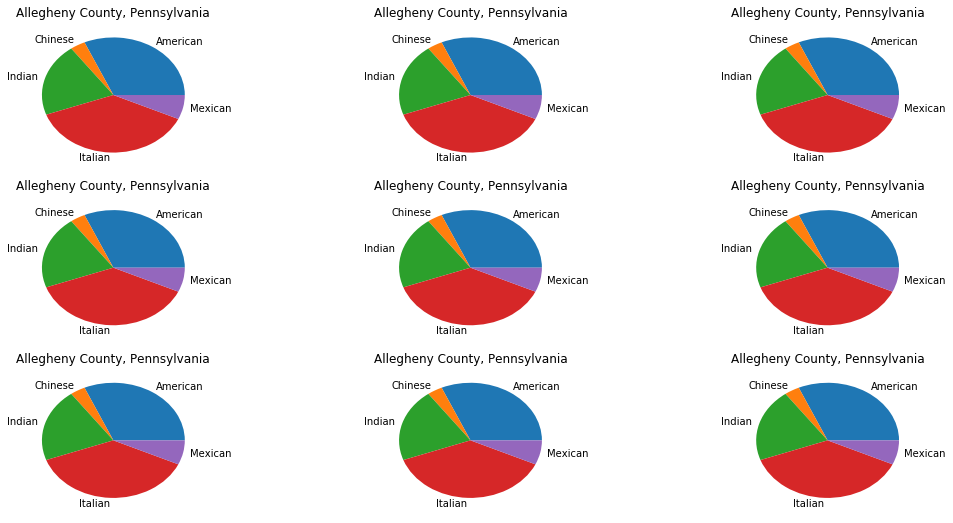

In [104]:
plt.show()

In [ ]:
comp = pd.DataFrame(res_df["category"].groupby(res_df["county_string"]).value_counts())
comp
#I HAVE NO IDEA WHAT TO DO WITH THIS

In [105]:
CHA = CHA["category"].value_counts().reset_index()
CHA["county_string"]="Mecklenburg County, North Carolina"
CHA.columns = ["category","count","county_string"]
CHA

NameError: name 'CHA' is not defined